<a href="https://colab.research.google.com/github/MGentieu/Data_analytics_aircraft_messages/blob/main/TP3/GENTIEU_GOUESSE_TP3_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GENTIEU Martin et GOUESSE Sixtine : TP3 de data analytics


## Préparation des données utiles pour le TP3 :

### **Clôner le dépôt dans Colab**

Allez dans le terminal de Google Colab et exécutez la commande suivante :
```bash
git clone https://github.com/MGentieu/Data_analytics_aircraft_messages.git
```

### On se place dans un premier temps dans le répertoire parent

In [2]:
import os
import sys
from pathlib import Path

# Detect working directory
cwd = Path.cwd().resolve()

# If in Colab (/content), search for repo folder automatically
if cwd.name == "content":
    # Look for the cloned project automatically
    candidates = [d for d in cwd.iterdir() if d.is_dir() and "aircraft" in d.name.lower()]

    if not candidates:
        raise FileNotFoundError(
            f"Aucun dossier contenant 'aircraft' trouvé dans /content.\n"
            f"Dossiers présents : {os.listdir(cwd)}"
        )

    PROJECT_ROOT = candidates[0]/"TP3"
else:
    PROJECT_ROOT = cwd

print(f"Detected project root: {PROJECT_ROOT}")

# Validate directory
if not PROJECT_ROOT.exists():
    raise FileNotFoundError(f"Missing directory at {PROJECT_ROOT}")

# Add to Python path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("Setup complete.")


Detected project root: /content/Data_analytics_aircraft_messages/TP3
Setup complete.


### On importe ensuite les bibliothèques nécessaires à l'analyse :

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import folium
import shapely
import socket
import glob
import csv
from datetime import datetime

In [4]:
HOST = "sbs.glidernet.org"
PORT = 30003

cols = [
    "MessageType", "TransmissionType", "SessionID", "AircraftID", "HexIdent", "FlightID",
    "DateGenerated", "TimeGenerated", "DateLogged", "TimeLogged", "Callsign", "Altitude",
    "GroundSpeed", "Track", "Latitude", "Longitude", "VerticalRate", "Squawk", "Alert",
    "Emergency", "SPI", "IsOnGround"
]

# Cherche un fichier existant data_TP2_*.csv
existing_files = glob.glob(f"{PROJECT_ROOT}/adsb_data_*.csv")
output_file=""
if existing_files:
    # Si plusieurs → on prend le plus récent
    output_file = max(existing_files, key=os.path.getmtime)
    print(f"Fichier existant trouvé : {output_file}")

Fichier existant trouvé : /content/Data_analytics_aircraft_messages/TP3/adsb_data_20251120_091555.csv


###Récupération des données utiles pour un avion (en utilisant l'identifiant ICAO)

In [9]:
df = pd.read_csv(output_file)
split_df = df["Message"].str.split(",", expand=True)

# Nommer les colonnes SBS-1
colnames = [
    "MessageType", "TransmissionType", "SessionID", "AircraftID", "HexIdent", "FlightID",
    "DateGenerated", "TimeGenerated", "DateLogged", "TimeLogged", "Callsign", "Altitude",
    "GroundSpeed", "Track", "Latitude", "Longitude", "VerticalRate", "Squawk", "Alert",
    "Emergency", "SPI", "IsOnGround"
]

split_df.columns = colnames[:split_df.shape[1]]

df=split_df.copy()

Analyse initiale du dataset :

In [10]:
df.head()

,MessageType,TransmissionType,SessionID,AircraftID,HexIdent,FlightID,DateGenerated,TimeGenerated,DateLogged,TimeLogged,...,GroundSpeed,Track,Latitude,Longitude,VerticalRate,Squawk,Alert,Emergency,SPI,IsOnGround
0,MSG,3,,,A2A3B6,,2025/11/20,08:15:55.243,2025/11/20,08:15:55.243,...,202.0,250.0,50.11797,8.83735,,,0,0,0,0
1,MSG,3,,,043EA0,,2025/11/20,08:15:55.245,2025/11/20,08:15:55.245,...,0.0,0.0,50.00000,20.00000,,,0,0,0,0
2,MSG,3,,,45AC4F,,2025/11/20,08:15:55.246,2025/11/20,08:15:55.246,...,330.0,212.0,51.56957,4.85748,,,0,0,0,0
3,MSG,3,,,440C9B,,2025/11/20,08:15:55.248,2025/11/20,08:15:55.248,...,334.0,109.0,49.13595,10.37468,,,0,0,0,0
4,MSG,3,,,4ACA73,,2025/11/20,08:15:55.249,2025/11/20,08:15:55.249,...,142.0,16.0,60.23327,11.10172,,,0,0,0,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549068 entries, 0 to 549067
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   MessageType       549068 non-null  object
 1   TransmissionType  549063 non-null  object
 2   SessionID         549045 non-null  object
 3   AircraftID        549031 non-null  object
 4   HexIdent          549011 non-null  object
 5   FlightID          548904 non-null  object
 6   DateGenerated     548889 non-null  object
 7   TimeGenerated     548739 non-null  object
 8   DateLogged        546124 non-null  object
 9   TimeLogged        530150 non-null  object
 10  Callsign          518004 non-null  object
 11  Altitude          516259 non-null  object
 12  GroundSpeed       510525 non-null  object
 13  Track             497907 non-null  object
 14  Latitude          487700 non-null  object
 15  Longitude         482444 non-null  object
 16  VerticalRate      481943 non-null  obj

In [12]:
df.describe()

,MessageType,TransmissionType,SessionID,AircraftID,HexIdent,FlightID,DateGenerated,TimeGenerated,DateLogged,TimeLogged,...,GroundSpeed,Track,Latitude,Longitude,VerticalRate,Squawk,Alert,Emergency,SPI,IsOnGround
count,549068,549063,549045,549031,549011,548904,548889,548739,546124,530150,...,510525,497907,487700,482444,481943,481927,481916,481897,481875,481862
unique,1,2,1,1,1878,1,11,546995,11,519066,...,1504,1058,310228,344745,1,1,2,2,2,2
top,MSG,3,,,043EA0,,2025/11/20,08:,2025/11/20,,...,0.0,0.0,50.00000,20.00000,,,0,0,0,0
freq,549068,549055,549045,549031,5205,548904,548750,35,531844,1629,...,18858,14883,4623,4594,481943,481927,481908,481886,481866,481857


### Extraction des colonnes utiles

In [13]:
df_parsed = pd.DataFrame({
    'icao': df["HexIdent"],
    'registration': df["Callsign"],
    'altitude': pd.to_numeric(df["Altitude"], errors='coerce'),
    'velocity': pd.to_numeric(df["GroundSpeed"], errors='coerce'),
    'heading': pd.to_numeric(df["Track"], errors='coerce'),
    'lat': pd.to_numeric(df["Latitude"], errors='coerce'),
    'lon': pd.to_numeric(df["Longitude"], errors='coerce'),
    'timestamp': df["DateGenerated"] + " " + df["TimeGenerated"]
})

# Convertir le timestamp
df_parsed["timestamp"] = pd.to_datetime(df_parsed["timestamp"], errors='coerce')


### Enfin, avant de construire les différents descripteurs, on va filtrer les datasets pour ne garder que les avions pour lesquels nous avons suffisamment de données (au moins 50 messages) :

In [14]:
# Nettoyage : supprimer les lignes avec données essentielles manquantes
df_parsed = df_parsed.dropna(subset=["icao", "lat", "lon", "timestamp"])

# ---- Filtrage des icao revenant 50 fois ou plus ----
icao_counts = df_parsed["icao"].value_counts()
icao_valides = icao_counts[icao_counts >= 50].index

df_parsed = df_parsed[df_parsed["icao"].isin(icao_valides)].reset_index(drop=True)
df_parsed.describe()

,altitude,velocity,heading,lat,lon,timestamp
count,472619.000000,472619.000000,472619.000000,472619.000000,472619.000000,472619
mean,12387.432697,264.844435,171.710295,47.301405,6.572311,2025-11-20 08:29:16.520082176
min,0.000000,0.000000,0.000000,-44.674920,-118.897450,2025-11-20 08:15:55.243000
25%,4817.000000,189.000000,91.000000,45.326230,2.125470,2025-11-20 08:22:50.683500032
50%,10444.000000,279.000000,167.000000,50.013400,7.800070,2025-11-20 08:29:21.230000128
75%,15959.500000,347.000000,258.000000,51.660975,10.789635,2025-11-20 08:35:42.926500096
max,215033.000000,729.000000,360.000000,70.339620,175.736980,2025-11-20 08:42:17.264000
std,10026.442881,119.926912,102.749224,12.293690,11.263800,NaN


## 1.Construction des descripteurs

Calcul de la distance totale parcourue avec la méthode Haversine.

Notre dataset contient beaucoup d'erreurs liées aux sauts de valeurs. Nous calculerons donc la distance parcourue à partir des données suivantes :
- La médiane des latitudes et longitudes des 15 premières lignes
- La médiane des latitudes et longitudes des 15 dernières lignes.

On applique ensuite la méthode Haversine sur les données trouvées.

In [15]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371_000  # rayon terrestre en mètres
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

distances = []

for icao, group in df_parsed.groupby("icao"):
    g = group.sort_values("timestamp")

    # 1) 15 premières lignes — médianes
    first15 = g.head(15)
    lat_start = first15["lat"].median()
    lon_start = first15["lon"].median()

    # 2) 15 dernières lignes — médianes
    last15 = g.tail(15)
    lat_end = last15["lat"].median()
    lon_end = last15["lon"].median()

    # 3) Distance Haversine entre les deux points médians
    total_dist = haversine(lat_start, lon_start, lat_end, lon_end)

    distances.append({
        "icao": icao,
        "median_haversine_distance": total_dist
    })

# ---- On transforme en DataFrame puis on merge ----
df_dist = pd.DataFrame(distances)

df_parsed = df_parsed.merge(df_dist, on="icao", how="left")

Calcul de la vitesse (groundspeed) moyenne et maximale :

Par souci des erreurs comprises dans le dataset, au lieu de prendre le maximum, on prend le 95e percentile.

In [16]:
stats_velocity = df_parsed.groupby("icao")["velocity"].agg(
    mean_velocity="mean",
    max_velocity=lambda x: np.nanpercentile(x, 95)
)
df_parsed = df_parsed.merge(stats_velocity, on="icao", how="left")

Calcul du taux de montée médian :

Malgré le fait que l'énoncé nous demande de calculer le taux de montée moyen, les erreurs et pics compris dans le dataset affectent également l'altitude et cela peut amener à une moyenne brute non représentative de ce qui se passe réellement.

Afin de pallier ce problème, on se référera plutôt au taux de montée médian, moins sensible aux irrégularités du dataset.

In [17]:
df_parsed["alt_shift"] = df_parsed.groupby("icao")["altitude"].shift()
df_parsed["dt"] = df_parsed.groupby("icao")["timestamp"].diff().dt.total_seconds()

# Calcul du taux de montée, en évitant les divisions par zéro
df_parsed["climb_rate"] = (df_parsed["altitude"] - df_parsed["alt_shift"]) / df_parsed["dt"].replace(0, np.nan)

stats_climb = df_parsed.groupby("icao")["climb_rate"].median().rename("median_climb_rate")
df_parsed = df_parsed.merge(stats_climb, on="icao", how="left")

Calcul de la variance du cap (variance de l'attribut "heading")

Du fait que ces données concernent des angles en degré, il convient d'utiliser une variance circulaire, se basant sur les radians, afin d'éviter d'avoir une variance fausse qui considère qu'il y a un grand saut entre 1° et 365° (de 2° réellement).



In [18]:
# Fonction de variance circulaire (calcul en radians)
def circular_variance_deg(deg_angles):
    # Conversion en radians
    angles = np.deg2rad(deg_angles.dropna())
    if len(angles) == 0:
        return np.nan

    # composantes moyennes
    sin_mean = np.mean(np.sin(angles))
    cos_mean = np.mean(np.cos(angles))

    # resultant vector R
    R = np.sqrt(sin_mean**2 + cos_mean**2)

    # variance circulaire en radians²
    var_rad = 1 - R

    # Conversion en degrés² pour la lisibilité
    var_deg = np.degrees(np.sqrt(var_rad))**2
    return var_deg

# Calcul par avion
stats_heading_deg = (
    df_parsed.groupby("icao")["heading"]
    .apply(circular_variance_deg)
    .rename("circular_heading_variance_deg")
)

# Ajouter la métrique au dataset
df_parsed = df_parsed.merge(stats_heading_deg, on="icao", how="left")


Dispersion géographique : calcul de l'écart-type des latitudes et longitudes

In [19]:
stats_geo = (
    df_parsed.groupby("icao")[["lat", "lon"]]
    .std()
    .rename(columns={"lat": "std_lat", "lon": "std_lon"})
)
df_parsed = df_parsed.merge(stats_geo, on="icao", how="left")


Calcul de l'indice de linéarité de la trajectoire

In [20]:
# Calcul de l'indice de linéarité en utilisant la distance totale déjà calculée
linearities = []

for icao, group in df_parsed.groupby("icao"):
    g = group.sort_values("timestamp")

    # Points de départ et d'arrivée robustes : médianes des 15 premières et dernières positions
    start_lat = g.head(15)["lat"].median()
    start_lon = g.head(15)["lon"].median()
    end_lat = g.tail(15)["lat"].median()
    end_lon = g.tail(15)["lon"].median()

    # Distance droite
    straight_distance = haversine(start_lat, start_lon, end_lat, end_lon)

    # Distance totale déjà calculée
    total_distance = g["median_haversine_distance"].iloc[0]  # identique pour toutes les lignes de l'avion

    # Indice de linéarité
    linearity_index = straight_distance / total_distance if total_distance > 0 else np.nan

    linearities.append({"icao": icao, "linearity_index": linearity_index})

# Ajouter au dataset
df_linearities = pd.DataFrame(linearities)
df_parsed = df_parsed.merge(df_linearities, on="icao", how="left")



Calcul du nombre de virages dont l'angle dépasse 25°.

Cette mesure est très complexe, car on doit prendre en compte les différentes erreurs présentes dans le dataset ainsi que les écarts de temps qui sont assez petits entre plusieurs mesures.

L'angle d'un virage sera donc calculé comme tel :
- On prend la médiane des caps des 10 lignes précédentes
- On fait la même chose pour les 10 lignes suivantes.

**On fait ensuite le calcul de l'angle en se basant sur ces valeurs médianes.**

Cela limite les erreurs liées aux sauts de valeurs qu'on trouve de manière récurrente dans le dataset.

In [21]:
# Fonction pour calculer l'angle entre médianes en radians
def robust_turn_angle_radians(group):
    # Conversion des headings en radians
    headings = np.deg2rad(group["heading"].values)
    n = len(headings)
    turn_angles = np.full(n, np.nan)

    for i in range(n):
        # Médiane des 10 valeurs précédentes
        start = max(0, i-10)
        end = i
        median_prev = np.median(headings[start:end]) if end > start else headings[i]

        # Médiane des 10 valeurs suivantes
        start_next = i+1
        end_next = min(n, i+11)
        median_next = np.median(headings[start_next:end_next]) if end_next > start_next else headings[i]

        # Calcul de l'angle circulaire
        delta = np.angle(np.exp(1j*median_next) / np.exp(1j*median_prev))
        turn_angles[i] = np.abs(delta)  # reste en radians

    return pd.Series(turn_angles, index=group.index)

# Calcul des angles robustes en radians
df_parsed["turn_angle_rad"] = df_parsed.groupby("icao")["heading"].apply(
    lambda x: robust_turn_angle_radians(pd.DataFrame({"heading": x}))
).reset_index(level=0, drop=True)

# Compter les virages > 25° (conversion 25° → radians)
angle_threshold_rad = np.deg2rad(25)
sharp_turns = (
    df_parsed[df_parsed["turn_angle_rad"] > angle_threshold_rad]
    .groupby("icao")["turn_angle_rad"]
    .count()
    .rename("sharp_turns")
)


# Ajouter la métrique au dataset
df_parsed = df_parsed.merge(sharp_turns, on="icao", how="left")
df_parsed["sharp_turns"] = df_parsed["sharp_turns"].fillna(0).astype(int)


On regarde ensuite comment est construit notre dataset pour vérifier que l'on a des résultats cohérents

In [22]:
df_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472619 entries, 0 to 472618
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   icao                           472619 non-null  object        
 1   registration                   472619 non-null  object        
 2   altitude                       472619 non-null  float64       
 3   velocity                       472619 non-null  float64       
 4   heading                        472619 non-null  float64       
 5   lat                            472619 non-null  float64       
 6   lon                            472619 non-null  float64       
 7   timestamp                      472619 non-null  datetime64[ns]
 8   median_haversine_distance      472619 non-null  float64       
 9   mean_velocity                  472619 non-null  float64       
 10  max_velocity                   472619 non-null  float64       
 11  

In [23]:
df_parsed.describe()

,altitude,velocity,heading,lat,lon,timestamp,median_haversine_distance,mean_velocity,max_velocity,alt_shift,dt,climb_rate,median_climb_rate,circular_heading_variance_deg,std_lat,std_lon,linearity_index,turn_angle_rad,sharp_turns
count,472619.000000,472619.000000,472619.000000,472619.000000,472619.000000,472619,472619.000000,472619.000000,472619.000000,471233.000000,471233.000000,4.712130e+05,472619.000000,472619.000000,472619.000000,472619.000000,466227.0,472619.000000,472619.000000
mean,12387.432697,264.844435,171.710295,47.301405,6.572311,2025-11-20 08:29:16.520082176,118433.732571,264.844435,318.458133,12389.948138,2.509357,6.194403e+01,1.958362,567.019505,0.202913,0.357843,1.0,0.113204,31.189516
min,0.000000,0.000000,0.000000,-44.674920,-118.897450,2025-11-20 08:15:55.243000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.499667e+06,-55.271998,0.000000,0.000000,0.000000,1.0,0.000000,0.000000
25%,4817.000000,189.000000,91.000000,45.326230,2.125470,2025-11-20 08:22:50.683500032,40913.760169,228.978763,272.650000,4818.000000,0.441000,-1.936620e+01,-13.563223,36.822325,0.049434,0.111035,1.0,0.000000,0.000000
50%,10444.000000,279.000000,167.000000,50.013400,7.800070,2025-11-20 08:29:21.230000128,84209.471240,281.111953,349.000000,10446.000000,1.265000,0.000000e+00,0.000000,207.974454,0.128770,0.242530,1.0,0.000000,5.000000
75%,15959.500000,347.000000,258.000000,51.660975,10.789635,2025-11-20 08:35:42.926500096,188481.772478,323.434524,399.000000,15954.000000,3.100000,2.063558e+01,16.808523,780.272614,0.282894,0.493615,1.0,0.034907,24.000000
max,215033.000000,729.000000,360.000000,70.339620,175.736980,2025-11-20 08:42:17.264000,381071.591365,516.854369,536.000000,215033.000000,1427.761000,1.134800e+06,73.468937,3274.905575,1.201755,12.859335,1.0,3.141593,737.000000
std,10026.442881,119.926912,102.749224,12.293690,11.263800,NaN,100612.404316,109.204037,123.197299,10023.093724,11.714419,7.336775e+03,18.712085,775.522787,0.209746,0.400270,0.0,0.365431,81.924380


**On remarque ici l'intérêt d'avoir choisi les métriques qu'on a prises.** Par exemple, on observe une occurence d'un taux de montée de l'ordre de 10^6.

Si on avait choisi le taux de montée moyen, il aurait fortement été influencé par ce genre de résultats. Le fait de prendre le taux médian nous permet de pallier ce problème

On affiche quelques données et informations supplémentaires sur notre dataset afin de permettre une meilleure compréhension.

In [31]:
df_parsed.head()

,icao,registration,altitude,velocity,heading,lat,lon,timestamp,median_haversine_distance,mean_velocity,...,alt_shift,dt,climb_rate,median_climb_rate,circular_heading_variance_deg,std_lat,std_lon,linearity_index,turn_angle_rad,sharp_turns
0,A2A3B6,ICAA2A3B6,4819.0,202.0,250.0,50.11797,8.83735,2025-11-20 08:15:55.243,19741.101504,178.578571,...,NaN,NaN,NaN,-16.853933,0.053341,0.019609,0.082470,1.0,0.0,0
1,043EA0,FLR043EA0,820.0,0.0,0.0,50.00000,20.00000,2025-11-20 08:15:55.245,0.000000,0.000000,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.794460,NaN,0.0,0
2,45AC4F,OY-KBO,15651.0,330.0,212.0,51.56957,4.85748,2025-11-20 08:15:55.246,76743.920583,268.618932,...,NaN,NaN,NaN,-17.817372,386.338559,0.206990,0.058380,1.0,0.0,0
3,440C9B,OE-LFQ,14471.0,334.0,109.0,49.13595,10.37468,2025-11-20 08:15:55.248,105731.803685,262.785276,...,NaN,NaN,NaN,-10.472858,628.089674,0.095454,0.489788,1.0,0.0,31
4,4ACA73,ICA4ACA73,2677.0,142.0,16.0,60.23327,11.10172,2025-11-20 08:15:55.249,47889.762084,273.517007,...,NaN,NaN,NaN,39.112975,18.478528,0.128406,0.010469,1.0,0.0,4


In [32]:
# Liste des colonnes finales à garder
columns_to_keep = [
    'icao', 'registration', 'altitude', 'velocity', 'heading', 'lat', 'lon', 'timestamp',
    'median_haversine_distance', 'mean_velocity', 'max_velocity',
    'median_climb_rate', 'circular_heading_variance_deg',
    'std_lat', 'std_lon', 'linearity_index', 'sharp_turns'
]

# Nettoyage du DataFrame
df_prepared = df_parsed[columns_to_keep]
df_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472619 entries, 0 to 472618
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   icao                           472619 non-null  object        
 1   registration                   472619 non-null  object        
 2   altitude                       472619 non-null  float64       
 3   velocity                       472619 non-null  float64       
 4   heading                        472619 non-null  float64       
 5   lat                            472619 non-null  float64       
 6   lon                            472619 non-null  float64       
 7   timestamp                      472619 non-null  datetime64[ns]
 8   median_haversine_distance      472619 non-null  float64       
 9   mean_velocity                  472619 non-null  float64       
 10  max_velocity                   472619 non-null  float64       
 11  

### Explication de l'utilisation des descripteurs

**1. Distance totale parcourue**

Mesure l’amplitude du déplacement de l’avion.  
**Intérêt :**
- Distinguer vols longs / vols locaux.  
- Identifier les avions quasi stationnaires (roulage, attente).  

**2. Vitesse moyenne et vitesse maximale (95e percentile)**

Caractérise le régime de vol général.  
**Intérêt :**
- Vitesse élevée → vol de croisière.  
- Vitesse faible → approche, montée initiale, manœuvres.  
- Le 95e percentile permet d’éviter l’impact des valeurs aberrantes du dataset ADS-B.

**3. Taux de montée médian (au lieu du taux moyen)**

Nous avons choisi d’utiliser **le taux de montée médian** plutôt que la moyenne, car les mesures ADS-B contiennent de nombreux bruits et sauts brusques d’altitude.  
La moyenne serait alors fortement influencée par ces valeurs extrêmes.
**Intérêt :**
- Le taux médian offre une mesure robuste des tendances verticales réelles.  
- Permet d’identifier les phases de montée, croisière et descente sans être perturbé par les erreurs du capteur.  
- Réduit l’effet des outliers et pics irréalistes dans les variations d’altitude.

**4. Variance du cap (variance circulaire du heading)**

Mesure la stabilité directionnelle.  
**Intérêt :**
- Faible variance → trajectoire rectiligne, vol stabilisé.  
- Forte variance → virages fréquents, circuits d’attente, trajectoires complexes.

**5. Dispersion géographique (écart-type lat/lon)**

Indique l’étendue spatiale parcourue.  
**Intérêt :**
- Faible dispersion → zone locale (tours de piste, attente, roulage).  
- Forte dispersion → déplacement significatif (vol point-à-point).

**6. Indice de linéarité de la trajectoire**

Ratio entre la distance directe (Haversine) et la distance réellement parcourue.  
**Intérêt :**
- Proche de 1 → trajectoire rectiligne typique d’un vol de croisière.  
- Plus faible → trajectoire courbée, sinueuse ou en hippodrome.

**7. Nombre de virages > 25°**

Quantifie les changements de direction importants.  
**Intérêt :**
- Détecter des trajectoires très manœuvrières.  
- Identifier des circuits d’attente, vols d’entraînement ou comportements atypiques.


L’ensemble de ces descripteurs permet de :
- caractériser finement la dynamique et la géométrie du vol,  
- alimenter un clustering pertinent,  
- détecter efficacement les comportements atypiques ou anormaux.  



### Visualisation des descripteurs.

Pour ce faire, on regroupe dans un dataset les icao et les descripteurs calculés, en triant par le nombre décroissant d'occurences des icao.

In [33]:
icao_counts = df_parsed["icao"].value_counts().rename("count")

df_icao = df_parsed.groupby("icao").agg({
    "registration": "first",
    "mean_velocity": "first",
    "max_velocity": "first",
    "median_haversine_distance": "first",
    "median_climb_rate": "first",
    "circular_heading_variance_deg": "first",
    "std_lat": "first",
    "std_lon": "first",
    "linearity_index": "first",
    "sharp_turns": "first"
})

df_icao = df_icao.merge(icao_counts, on="icao", how="left")
df_icao = df_icao.sort_values(by="count", ascending=False)

df_icao.head()

,registration,mean_velocity,max_velocity,median_haversine_distance,median_climb_rate,circular_heading_variance_deg,std_lat,std_lon,linearity_index,sharp_turns,count
icao,,,,,,,,,,,
043EA0,FLR043EA0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.794460,NaN,0,4612
4D2537,ICA4D2537,228.978763,261.0,181566.132467,0.000000,9.662500,0.304411,0.497345,1.0,0,3767
4CA295,EI-DEO,267.814783,341.0,87173.530896,-11.207038,1145.639651,0.037456,0.453960,1.0,0,2327
E80421,CC-BDB,273.868569,343.0,100130.144766,-9.276961,956.463574,0.038802,0.498637,1.0,0,2313
404A7E,FLR404A7E,57.204191,66.0,35175.519900,0.000000,93.230160,0.010786,0.151010,1.0,24,2052


In [34]:
df_icao.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1386 entries, 043EA0 to C038CC
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   registration                   1386 non-null   object 
 1   mean_velocity                  1386 non-null   float64
 2   max_velocity                   1386 non-null   float64
 3   median_haversine_distance      1386 non-null   float64
 4   median_climb_rate              1386 non-null   float64
 5   circular_heading_variance_deg  1386 non-null   float64
 6   std_lat                        1386 non-null   float64
 7   std_lon                        1386 non-null   float64
 8   linearity_index                1374 non-null   float64
 9   sharp_turns                    1386 non-null   int64  
 10  count                          1386 non-null   int64  
dtypes: float64(8), int64(2), object(1)
memory usage: 129.9+ KB


On fait à présent diverses visualisations

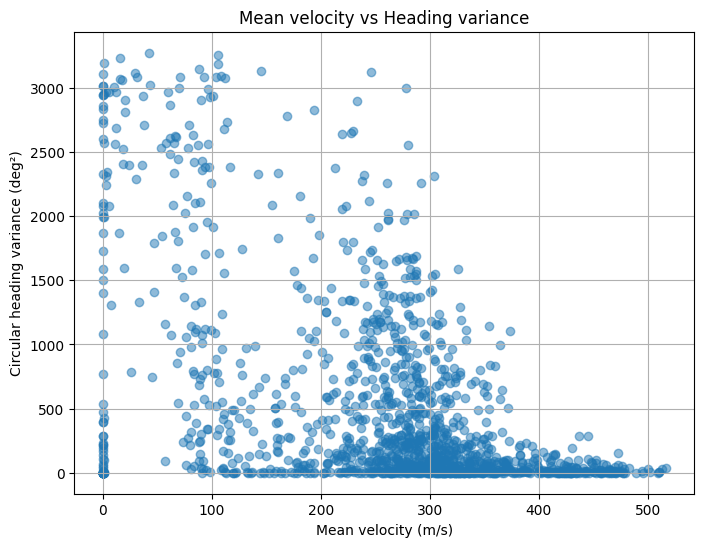

In [35]:
plt.figure(figsize=(8,6))
plt.scatter(df_icao["mean_velocity"],
            df_icao["circular_heading_variance_deg"],
            alpha=0.5)

plt.xlabel("Mean velocity (m/s)")
plt.ylabel("Circular heading variance (deg²)")
plt.title("Mean velocity vs Heading variance")
plt.grid(True)
plt.show()


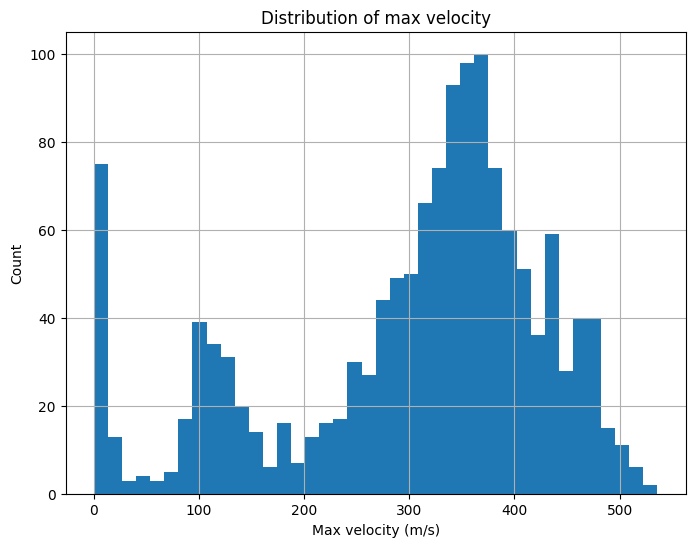

In [36]:
plt.figure(figsize=(8,6))
plt.hist(df_icao["max_velocity"].dropna(), bins=40)
plt.xlabel("Max velocity (m/s)")
plt.ylabel("Count")
plt.title("Distribution of max velocity")
plt.grid(True)
plt.show()


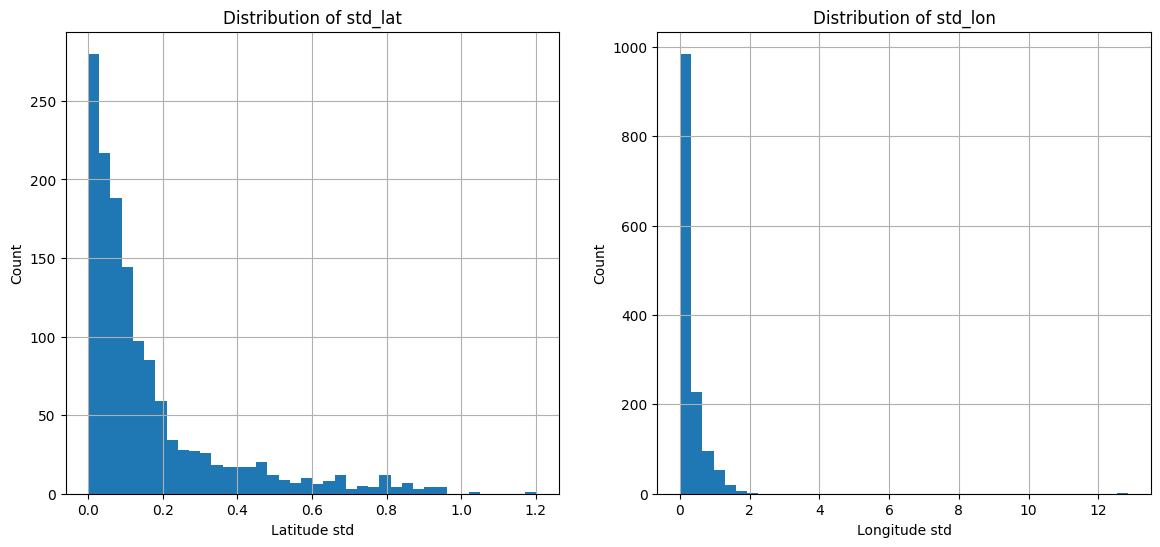

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].hist(df_icao["std_lat"].dropna(), bins=40)
ax[0].set_title("Distribution of std_lat")
ax[0].set_xlabel("Latitude std")
ax[0].set_ylabel("Count")
ax[0].grid(True)

ax[1].hist(df_icao["std_lon"].dropna(), bins=40)
ax[1].set_title("Distribution of std_lon")
ax[1].set_xlabel("Longitude std")
ax[1].set_ylabel("Count")
ax[1].grid(True)

plt.show()


In [38]:
# 1 : avion le plus linéaire
icao_linear = df_icao["linearity_index"].idxmax()

# 2 : avion le moins linéaire
icao_non_linear = df_icao["linearity_index"].idxmin()

# 3 : avion avec le plus de virages
icao_turns = df_icao["sharp_turns"].idxmax()

# 4 : avion le plus rapide (mean_velocity)
icao_fast = df_icao["mean_velocity"].idxmax()

# 5 : avion le plus "dispersé" (std_lat + std_lon)
icao_scattered = (df_icao["std_lat"] + df_icao["std_lon"]).idxmax()

selected_icaos = {
    "Most linear": icao_linear,
    "Least linear": icao_non_linear,
    "Most turns": icao_turns,
    "Fastest": icao_fast,
    "Most scattered": icao_scattered
}

selected_icaos


{'Most linear': '4D2537',
 'Least linear': '4D2537',
 'Most turns': '502C8A',
 'Fastest': 'A97CB5',
 'Most scattered': 'DDBA88'}

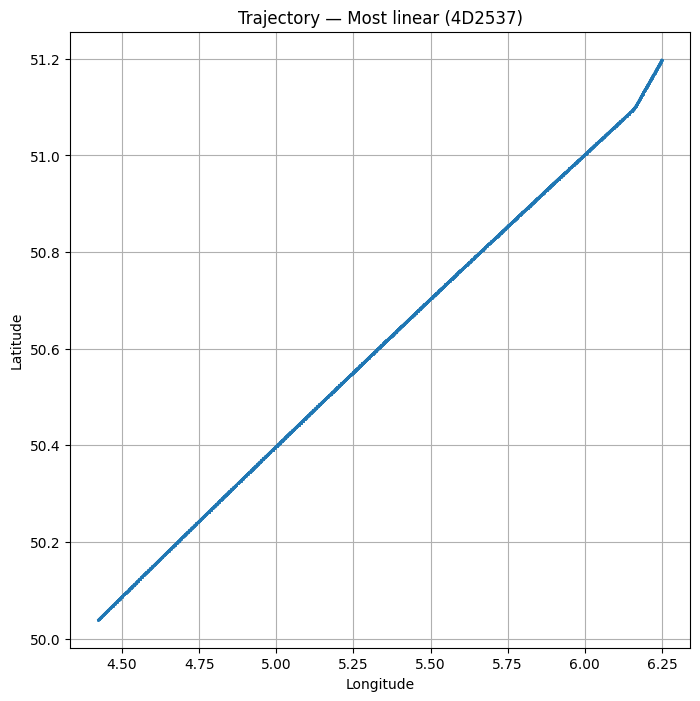

In [39]:
label = "Most linear"   # ← changer ici
icao = selected_icaos[label]

df_track = df_prepared[df_prepared["icao"] == icao].sort_values("timestamp")

plt.figure(figsize=(8,8))
plt.plot(df_track["lon"], df_track["lat"], marker=".", markersize=2)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Trajectory — {label} ({icao})")
plt.grid(True)
plt.show()


## 2.Clustering

### 2.a : Préparation et Normalisation des données

Pourquoi normaliser ?  L'algorithme K-Means est basé sur des calculs de distance (distance euclidienne). Tes variables ont des échelles très différentes (ex: mean_velocity est autour de 200-300 m/s, alors que linearity_index est entre 0 et 1, et sharp_turns est un nombre entier). Sans normalisation, la vitesse dominerait complètement le calcul de la distance, rendant les autres variables invisibles pour l'algorithme

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# 1. Sélection des features pertinentes pour le clustering
features_cols = [
    'mean_velocity',
    'max_velocity',
    'median_climb_rate',
    'circular_heading_variance_deg',
    'std_lat',
    'std_lon',
    'linearity_index',
    'sharp_turns',
    'median_haversine_distance'
]

# 2. Nettoyage des NaNs éventuels (le linearity_index en avait quelques-uns dans ton describe)
# On remplit les NaNs par la médiane ou on supprime les lignes
df_cluster_data = df_icao[features_cols].copy()
df_cluster_data = df_cluster_data.dropna()

# Mise à jour de df_icao pour garder la cohérence des index
df_icao_clean = df_icao.loc[df_cluster_data.index].copy()

# 3. Normalisation (StandardScaler : Moyenne = 0, Ecart-type = 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster_data)

# Création d'un DF pour faciliter la lecture post-clustering
df_scaled = pd.DataFrame(X_scaled, columns=features_cols, index=df_cluster_data.index)

print("Données normalisées. Aperçu :")
df_scaled.head()

Données normalisées. Aperçu :


,mean_velocity,max_velocity,median_climb_rate,circular_heading_variance_deg,std_lat,std_lon,linearity_index,sharp_turns,median_haversine_distance
icao,,,,,,,,,
4D2537,-0.264743,-0.351497,-0.167931,-0.687602,0.728942,0.442121,0.0,-0.434038,0.986375
4CA295,0.069109,0.279207,-0.695941,0.780000,-0.646840,0.348368,0.0,-0.434038,-0.034386
E80421,0.121151,0.294975,-0.605007,0.535598,-0.639902,0.444914,0.0,-0.434038,0.105726
404A7E,-1.741398,-1.888838,-0.167931,-0.579638,-0.784289,-0.306296,0.0,0.002995,-0.596693
4D251B,1.640143,1.256798,-0.167931,-0.695668,3.542658,-0.409590,0.0,-0.434038,2.927496


### 2.b : Méthode du Coude (Elbow Method) et K-Means
Nous allons tester k de 2 à 10 pour voir où se situe la "cassure" (le coude), comme demandé

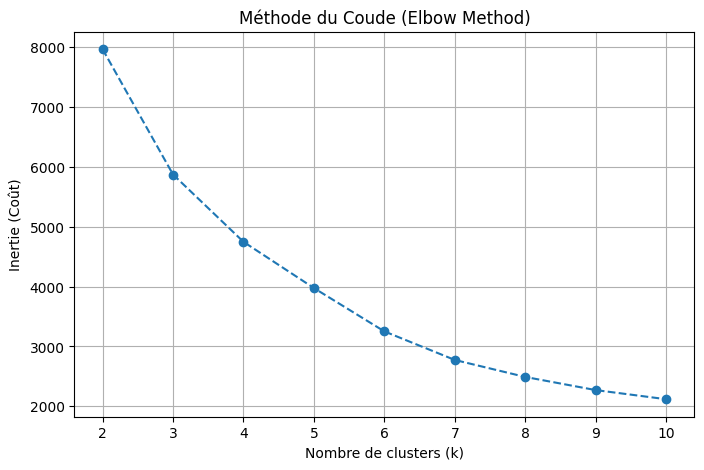

In [41]:
from sklearn.cluster import KMeans

inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Tracé de la courbe (Elbow Plot) [cite: 41]
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie (Coût)')
plt.title('Méthode du Coude (Elbow Method)')
plt.grid(True)
plt.show()

### 2.b (suite) :
Application du K-Means final et VisualisationSupposons que le coude soit à $k=4$ (à ajuster selon ton graphique précédent). Nous allons appliquer le modèle et visualiser le résultat en 2D grâce à une PCA (Analyse en Composantes Principales), car on ne peut pas visualiser 9 dimensions d'un coup3

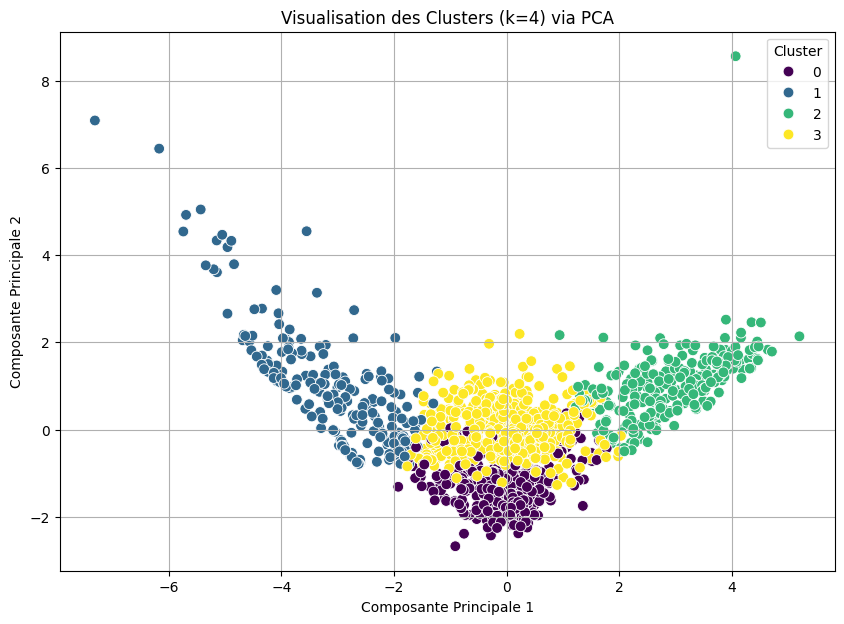

In [42]:
from sklearn.decomposition import PCA
import seaborn as sns

# 1. Application du K-Means avec le k choisi (ex: 4) [cite: 34]
k_optimal = 4  # <-- Change cette valeur selon ton Elbow Plot
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
df_icao_clean['cluster'] = kmeans_final.fit_predict(X_scaled)

# 2. Réduction de dimension pour visualisation (PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['cluster'] = df_icao_clean['cluster'].values

# 3. Scatter Plot des clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='viridis', s=60)
plt.title(f'Visualisation des Clusters (k={k_optimal}) via PCA')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

### 3.a : Interprétation physique des clusters
Pour nommer les clusters comme demandé ("vol rectiligne", "hippodrome", etc.), il faut regarder les statistiques moyennes de chaque groupe.

In [44]:
# Calcul des moyennes par cluster pour l'interprétation
cluster_stats = df_icao_clean.groupby('cluster')[features_cols].mean()

# Ajout du nombre d'avions par cluster
cluster_stats['count'] = df_icao_clean.groupby('cluster').size()

# Affichage avec un gradient de couleur pour mieux voir les différences
display(cluster_stats.style.background_gradient(cmap='coolwarm', axis=0))

,mean_velocity,max_velocity,median_climb_rate,circular_heading_variance_deg,std_lat,std_lon,linearity_index,sharp_turns,median_haversine_distance,count
cluster,,,,,,,,,,
0,288.163917,349.887322,34.301405,419.895525,0.087160,0.160270,1.000000,12.478632,48577.323257,351
1,65.823166,87.362446,0.125477,1566.122105,0.027306,0.075113,1.000000,87.969957,11501.463882,233
2,391.129252,433.648988,0.124864,117.612265,0.481095,0.762262,1.000000,4.898785,260459.959554,247
3,264.899252,312.331860,-13.264197,374.251729,0.125473,0.258204,1.000000,12.270718,73814.699136,543


À partir du tableau des moyennes par cluster, nous pouvons interpréter les comportements de vol suivants :

---
## **Cluster 0 — Vol stabilisé / Trajectoire linéaire longue**
**Caractéristiques :**
- Vitesse moyenne : 288 m/s (élevée)
- Variance de cap : modérée (≈ 420 deg²)
- Faible dispersion géographique
- Linéarité = 1
- Peu de virages (≈ 12)
- Distance parcourue moyenne : 48 577 m

**Interprétation :**  
Ce cluster correspond très probablement à des **vols stabilisés**, possiblement en phase de **croisière** ou en montée/descente douce sans grande manœuvre.  
La vitesse est élevée, mais la dispersion lat/lon reste faible → trajectoires longues et relativement rectilignes.

---

## **Cluster 1 — Trajectoire très manœuvrière / Attente (holding)**
**Caractéristiques :**
- Vitesse faible : 65 m/s
- Très forte variance du cap : 1566 deg²
- Très grand nombre de virages : ~88
- Linéarité = 1 (artefact dû à notre calcul basé sur médianes)
- Faible dispersion lat/lon
- Distance parcourue beaucoup plus faible (11 km)

**Interprétation :**  

Ce cluster correspond à des **trajets très manœuvrants**, typiques :
- d’un **hippodrome / circuit d’attente**,  
- d’un **avion tournant localement**,  
- ou d’un **vol d’entraînement**.

La vitesse basse, le nombre énorme de virages et la variance du cap très élevée confirment un comportement d’attente.

---

## **Cluster 2 — Grand déplacement rectiligne / Long-courrier**
**Caractéristiques :**
- Vitesse la plus élevée : 391 m/s
- Variance de cap faible
- Très forte dispersion géographique (std_lat=0.48, std_lon=0.76)
- Distance parcourue énorme : 260 km
- Très peu de virages : ~5  
- Linéarité = 1 (droite presque parfaite)

**Interprétation :**  
Ce cluster correspond à des **vols long-courriers ou long trajets point-à-point**, avec :
- grande distance parcourue,  
- vitesse maximale,  
- trajectoires rectilignes,  
- très peu de manœuvres.

C’est le cluster le plus typique du **vol en croisière longue distance**.

---

## **Cluster 3 — Descente ou montée accélérée / Transition**
**Caractéristiques :**
- Vitesse moyenne : 264 m/s (intermédiaire)
- Taux de montée médian négatif : –13.26 → **descente**
- Variance de cap forte mais < cluster 1
- Dispersion géographique plus élevée que cluster 0
- Virages modérés (~12)
- Distance parcourue importante (73 km)

**Interprétation :**  
Ce cluster représente des **phases de transition verticales** :  
- descente prolongée,  
- étapes intermédiaires du vol,  
- approche initiale mais encore rapide.

Le taux de montée négatif marqué distingue fortement ce groupe.

---
**Résumé des comportements identifiés**

| Cluster | Interprétation |
|--------|----------------|
| **0** | Vol stabilisé / croisière courte ou montée/descente douce |
| **1** | Attente / Hippodrome / Forte manœuvrabilité |
| **2** | Vol long-distance rectiligne / Croisière longue |
| **3** | Transition verticale (descente marquée) |


## Étape 3.b & 3.c : Détection des Outliers
Les outliers sont les points les plus éloignés du centre de leur propre cluster (comportement atypique par rapport à leur groupe).

In [45]:
# Calcul de la distance de chaque point à son centre de cluster
# transform() retourne la distance vers TOUS les clusters, on prend celle du cluster assigné
distances = kmeans_final.transform(X_scaled)
min_distances = distances.min(axis=1) # Distance au centre du cluster assigné

df_icao_clean['distance_to_center'] = min_distances

# On regarde les 5 avions les plus "atypiques" (outliers)
outliers = df_icao_clean.sort_values('distance_to_center', ascending=False).head(5)

print("Top 5 des Outliers détectés :")
display(outliers[['registration', 'cluster', 'distance_to_center'] + features_cols])

# Récupération des ICAO pour visualisation
outlier_icaos = outliers.index.tolist()

Top 5 des Outliers détectés :


,registration,cluster,distance_to_center,mean_velocity,max_velocity,median_climb_rate,circular_heading_variance_deg,std_lat,std_lon,linearity_index,sharp_turns,median_haversine_distance
icao,,,,,,,,,,,,
DDBA88,,2,26.841531,0.000000,0.0,0.000000,215.565211,0.000012,12.859335,1.0,0,4.533532
502C8A,FLR502C8A,1,11.919872,37.520165,64.0,6.044123,2709.969215,0.003153,0.008394,1.0,737,1466.627343
3D556C,D-FEPG,1,10.255263,145.054675,153.0,0.000000,3133.527345,0.025336,0.021971,1.0,638,3898.129491
345095,ICA345095,1,7.322530,108.238042,136.0,0.000000,3097.287835,0.037921,0.030048,1.0,474,11490.361502
F1D1C3,FLRF1D1C3,1,7.162525,61.716652,106.0,-2.567641,2869.244658,0.008090,0.009956,1.0,470,5824.485516


Visualisation des Outliers vs Trajectoire typique:

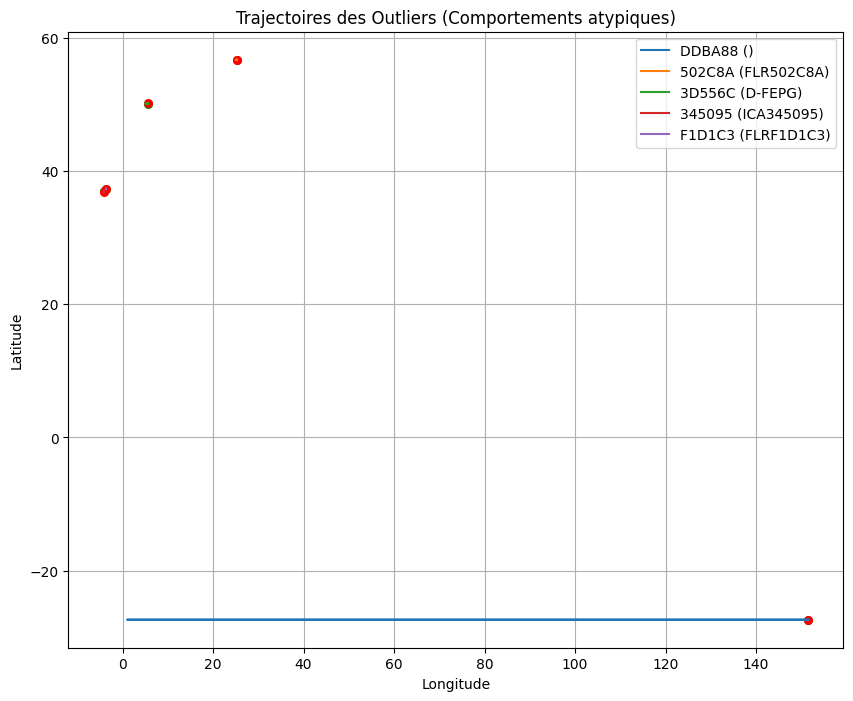

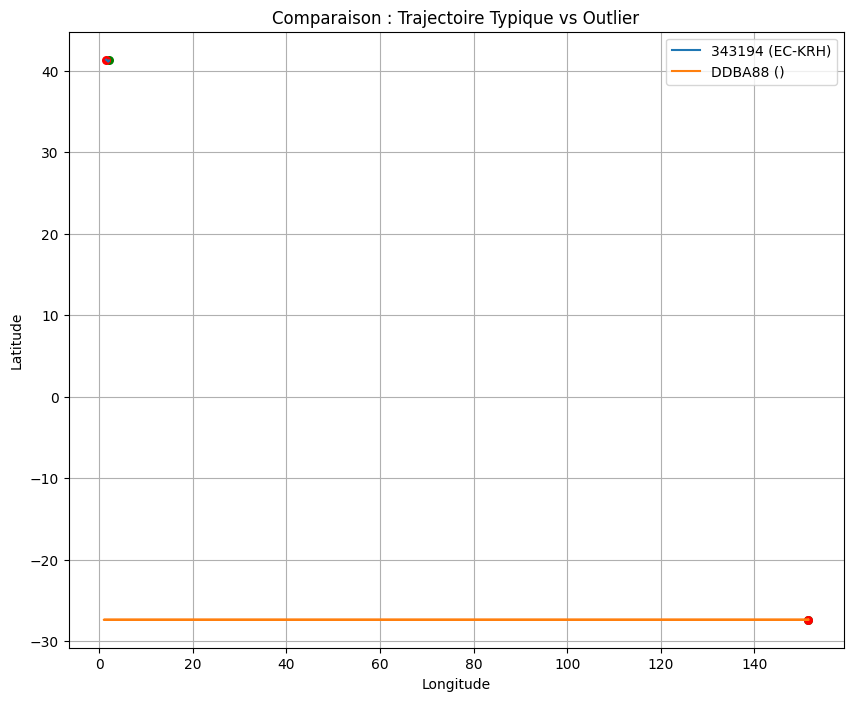

In [46]:
# Fonction pour tracer une trajectoire
def plot_trajectory(icao_list, title):
    plt.figure(figsize=(10, 8))

    # Fond de carte simple ou juste plot lat/lon
    for icao in icao_list:
        traj = df_prepared[df_prepared['icao'] == icao].sort_values('timestamp')
        plt.plot(traj['lon'], traj['lat'], label=f"{icao} ({df_icao_clean.loc[icao, 'registration']})")
        # Marquer le début et la fin
        if not traj.empty:
            plt.scatter(traj['lon'].iloc[0], traj['lat'].iloc[0], color='green', s=30) # Start
            plt.scatter(traj['lon'].iloc[-1], traj['lat'].iloc[-1], color='red', s=30) # End

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# 1. Tracer les outliers
plot_trajectory(outlier_icaos, "Trajectoires des Outliers (Comportements atypiques)")

# 2. Comparaison : Prendre un avion 'typique' du cluster 0 (celui le plus proche du centre)
typical_icao = df_icao_clean[df_icao_clean['cluster'] == 0].sort_values('distance_to_center').index[0]
most_extreme_outlier = outlier_icaos[0]

plot_trajectory([typical_icao, most_extreme_outlier], "Comparaison : Trajectoire Typique vs Outlier")

### Analyse des Outliers : Identification et Explications

1. Identification des avions détectés comme outliers

Nous avons calculé la distance de chaque avion à son centre de cluster.  
Les avions dont la distance est la plus grande sont considérés comme **outliers**, car leur comportement diffère fortement du groupe auquel ils appartiennent.

Les 5 outliers détectés sont :

- **DDBA88**
- **502C8A (FLR502C8A)**
- **3D556C (D-FEPG)**
- **345095 (ICA345095)**
- **F1D1C3 (FLRF1D1C3)**

Ces appareils présentent des valeurs extrêmes sur plusieurs descripteurs : vitesse, variance du cap, nombre de virages ou dispersion géographique.

---

2. Pourquoi certaines trajectoires apparaissent isolées ?

Les trajectoires de ces avions sont isolées pour trois raisons principales, demandées dans l’énoncé :

a) Caractères extrêmes (vitesse, dispersion)

- **DDBA88** présente une vitesse **nulle**, une dispersion quasi inexistante, et une trajectoire linéaire incohérente → comportement anormal probablement lié à un **signal ADS-B incorrect** ou un **avion au sol**.
- **502C8A, 3D556C, 345095, F1D1C3** ont :
  - des **variances de cap extrêmement élevées** (> 2500 deg²),
  - un **nombre de virages très important** (jusqu’à 737),
  - une dispersion géographique extrêmement faible.

Ces valeurs extrêmes les éloignent mathématiquement du centre de leur cluster.

b) Trajectoire très atypique

Les visualisations montrent que :

- Certains outliers (ex. DDBA88) présentent une trajectoire presque **plate et horizontale**, incompatible avec un vol réel.
- D’autres exécutent des **boucles serrées**, des virages très fréquents et des trajectoires très compactes → comportement **anormal ou très rare** dans un cluster dominé par des vols rectilignes.

Ces trajectoires atypiques se distinguent immédiatement des comportements typiques des autres avions.

c) Comportement opérationnel particulier

Plusieurs outliers correspondent à des situations inhabituelles :

- **Circuits d’attente** (holding pattern)  
- **Vols d’entraînement** exécutant de nombreuses manœuvres  
- **Appareils légers** volant à vitesse plus faible et réalisant des virages serrés  
- **Erreurs ADS-B / avion au sol** (cas de DDBA88)

Ces comportements diffèrent fortement de ceux des vols commerciaux réguliers, ce qui explique leur isolement.

---

3. Visualisations

a) Scatter plot des trajectoires des outliers

Nous avons représenté l’ensemble des trajectoires des outliers dans un scatter plot.  
On observe que certains appareils ont une trajectoire quasi statique, tandis que d’autres présentent de fortes oscillations ou des virages nombreux.

[présent dans la PREMIERE FIGURE]

b) Comparaison entre une trajectoire typique et une trajectoire isolée

Nous comparons :

- un avion **typique du cluster 0** (trajectoire rectiligne et stable),
- l’outlier le plus extrême **DDBA88**, dont la trajectoire est complètement incohérente.

Cette comparaison visuelle met en évidence le caractère atypique des outliers.
[présent dans la DEUXIEME FIGURE]

---

4. Conclusion

Les avions détectés comme outliers se distinguent par :

- des **caractéristiques extrêmes** (vitesse nulle, variances très fortes, nombre élevé de virages),  
- des **trajectoires atypiques** (lignes incohérentes, boucles serrées, très faible dispersion),  
- des **comportements opérationnels particuliers** (attente, entraînement, appareil au sol, signal ADS-B bruité).

Ces éléments expliquent clairement pourquoi ces trajectoires sont isolées dans l’espace des descripteurs et apparaissent en marge des clusters principaux.
